# Sketching for low-rank nonnegative matrix approximation

## 0.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import matplotlib_inline
# %matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
norms  = ['норма Чебышёва', 'норма Фробениуса', 'плотность']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-1, 16, 2)]

In [3]:
def svdr(a, r):
    u, s, vh = sp.linalg.svd(a, full_matrices=False)
    return u[:, :r], s[:r], vh[:r, :]

In [4]:
def TestMatrix(m, n, distribution='normal', p=None):
    if distribution == 'normal':
        res = np.random.normal(size=(m, n))
    elif distribution == 'rademacher' and p is None:
        res = np.random.choice([-1,1], size=(m,n))
    elif distribution == 'rademacher':
        res = np.random.choice([0,1,-1], size=(m,n), p=[1-p,p/2,p/2])
    else:
        raise TypeError('Invalid arguments')
    return res

In [5]:
def get_alg_name(alg, distr, **p):
    d = 'N' if distr=='normal' else 'Rad'
    if 'rho' in p.keys():
        rho = p.pop('rho')
    else:
        rho = None
    if len(p) < 2:
        p = list(p.values())[0]
        alg_name = f'{alg}({p}), {d}'
    else:
        if alg == 'HMT':
            p0 = p['p']
            p1 = p['k']
        elif alg == 'Tropp':
            p0 = p['k']
            p1 = p['l']
        alg_name = f'{alg}({p0},{p1}), {d}'
    if d == 'N':
        alg_name += '(0,1)'
    elif rho is not None:
        alg_name += f'({rho})'
    return alg_name

In [6]:
class Info:
    def __init__(self):
        self._info_l = None
        self._info_r = None
        
    def init(self, alg, params=None, l=0, r=None):
        self._alg = alg
        self._info_l = {'frobenius': [], 'chebyshev': [], 'density': []}
        if r is not None:
            self._info_r = {'frobenius': [], 'chebyshev': [], 'density': []}
        self._params  = params
        self._l = l
        self._r = r
  
    def clear(self):
        self._info_l = {'frobenius': [], 'chebyshev': [], 'density': []}
        if self._r is not None:
            self._info_r = {'frobenius': [], 'chebyshev': [], 'density': []}

    def update(self, a):
        a = a - self._l
        self._info_l['frobenius'].append(np.linalg.norm(a[a < 0]))
        neg_count = (a < 0).sum()
        self._info_l['density'].append(neg_count/(np.prod(a.shape)))
        self._info_l['chebyshev'].append(np.max(abs(a[a < 0]), initial=0))
        if self._r is not None:
            a = -(a - self._r)
            self._info_r['frobenius'].append(np.linalg.norm(a[a < 0]))
            neg_count = (a < 0).sum()
            self._info_r['density'].append(neg_count/(np.prod(a.shape)))
            self._info_r['chebyshev'].append(np.max(abs(a[a < 0]), initial=0))
        
    def get_info(self):
        if self._r is not None:
            return self._info_l, self._info_r
        else:
            return self._info_l
    
    def get_name(self):
        if self._alg in ['SVD', 'Tangent']:
            return self._alg
        return get_alg_name(self._alg, **self._params)    
    
    def __add__(self, info2):
        if info2._r is None:
            info2_l = info2.get_info()
        else:
            info2_l, info2_r = info2.get_info()
        if self._info_l is None:
            self._info_l = info2_l
            if info2._r is not None:
                self._info_r = info2_r
            self._alg = info2._alg
            self._params = info2._params
            self._l = info2._l
            self._r = info2._r
        else:
            for norm in self._info_l:
                self._info_l[norm] = list(np.array(self._info_l[norm]) + np.array(info2_l[norm]))
                if self._r is not None:
                    self._info_r[norm] = list(np.array(self._info_r[norm]) + np.array(info2_r[norm]))
        return self          
    
    def __truediv__(self, den):
        for norm in self._info_l:
            self._info_l[norm] = [x/den for x in self._info_l[norm]]
        if self._r is not None:
            for norm in self._info_l:
                self._info_r[norm] = [x/den for x in self._info_r[norm]]
        return self
        

## 1. Algorithms

### 1.1 SVD (exact alternating projections)

In [7]:
def SVD(X, rank, s=100, left=0, right=None, info=None):
    if info is not None:
        info.init(alg='SVD', l=left, r=right)
    Ur, Sr, Vhr = svdr(X, rank)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < left] = left
        if right is not None:
            Yi[Yi > right] = right
        Ur, Sr, Vhr = svdr(Yi, rank)
        Yi = Ur * Sr @ Vhr
        if info is not None:
            info.update(Yi)
    return Ur, Sr, Vhr

### 1.2 Tangent (alternating projections via tangent spaces)

In [8]:
def Tangent(X, rank, s=100, left=0, right=None, info=None):
    if info is not None:
        info.init(alg='Tangent', l=left, r=right)
    Ur, Sr, Vhr = svdr(X, rank)
    Vr = Vhr.T
    Yi = Ur * Sr @ Vhr
    Im = np.eye(X.shape[0])
    In = np.eye(X.shape[1])
    for i in range(s):
        Yi[Yi < left] = left
        if right is not None:
            Yi[Yi > right] = right
        G1 = Ur.T @ Yi
        G2 = (Im - Ur@Ur.T) @ Yi @ Vr
        Q1, R1 = np.linalg.qr((In-Vr@Vr.T)@G1.T)
        Q2, R2 = np.linalg.qr(G2)
        Z = np.hstack((G1@Vr, R1.T))
        Z = np.vstack((Z, np.hstack((R2, np.zeros(R2.shape)))))
        U2r, Sr, V2hr = svdr(Z, rank)
        Ur = np.hstack((Ur, Q2)) @ U2r
        Vr = np.hstack((Vr, Q1)) @ V2hr.T
        Yi = Ur * Sr @ Vr.T
        
        if info is not None:
            info.update(Yi)
    return Ur, Sr, Vr.T

### 1.3 HMT

In [9]:
def HMT(X, rank, p, k, distr='normal', rho=None, s=100, left=0, right=None, info=None):
    if info is not None:
        info.init(alg='HMT', params=dict(p=p, k=k, distr=distr, rho=rho), l=left, r=right)
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, rank)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < left] = left
        if right is not None:
            Yi[Yi > right] = right
        Psi = TestMatrix(n, k, distr, rho)
        Z1 = Yi @ Psi
        Q, R = np.linalg.qr(Z1)
        for j in range(p):
            Z2 = Q.T @ Yi
            Q, R = np.linalg.qr(Z2.T)
            Z1 = Yi @ Q
            Q, R = np.linalg.qr(Z1)
        Z2 = Q.T @ Yi
        Ur, Sr, Vhr = svdr(Z2, rank)
        Ur = Q @ Ur
        Yi = Ur * Sr @ Vhr
        if info is not None:
            info.update(Yi)
    return Ur, Sr, Vhr

### 1.4 Tropp

In [10]:
def Tropp(X, rank, k, l, distr='normal', rho=None, s=100, left=0, right=None, info=None):
    if info:
        info.init(alg='Tropp', params=dict(k=k, l=l, distr=distr, rho=rho), l=left, r=right)
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, rank)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < left] = left
        if right is not None:
            Yi[Yi > right] = right
        Psi = TestMatrix(n, k, distr, rho)
        Phi = TestMatrix(l, m, distr, rho)
        Z = Yi @ Psi
        Q, R = np.linalg.qr(Z)
        W = Phi @ Q
        P, T = np.linalg.qr(W)
        G = np.linalg.inv(T) @ P.T @ Phi @ Yi
        Ur, Sr, Vhr = svdr(G, rank)
        Ur = Q @ Ur
        Yi = Ur * Sr @ Vhr
        if info is not None:
            info.update(Yi)
    return Ur, Sr, Vhr

### 1.5 GN (generalized Nystrom method)

In [11]:
def GN(X, rank, l, distr='normal', rho=None, s=100, left=0, right=None, info=None):
    if info is not None:
        info.init(alg='GN', params=dict(l=l, distr=distr, rho=rho), l=left, r=right)
    m, n = X.shape
    Yi = X.copy()
    for i in range(s):
        Yi[Yi < left] = left
        if right is not None:
            Yi[Yi > right] = right
        Psi = TestMatrix(n, rank, distr, rho)
        Phi = TestMatrix(l, m, distr, rho)
        Z = Yi @ Psi
        W = Phi @ Z
        Q, R = np.linalg.qr(W)
        V = (Phi@Yi).T @ Q
        U = Z @ np.linalg.inv(R)
        Yi = U @ V.T
        if info is not None:
            info.update(Yi)
    return U, V.T

## 2. Numerical experiments

### 2.1 Random uniform matrices

In [12]:
m = 256
n = 256
r = 64

In [13]:
a = np.random.rand(m, n)
u, s, vh = svdr(a, r)
ar = u*s@vh
_, s, _ = np.linalg.svd(a)
s /= s[0]

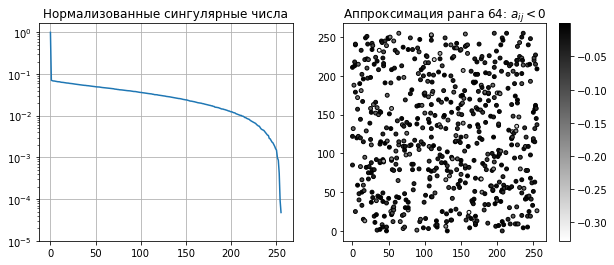

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title(r'Нормализованные сингулярные числа')
ax[0].plot(range(len(s)), s)
ax[0].set_yscale('log')
ax[0].set_yticks([10**(-x) for x in range(-int(np.log10(s[-1]))+2)])
ax[0].grid()

plt.set_cmap('gray_r')
ax[1].set_title(r'Аппроксимация ранга %d: $a_{ij} < 0$' % r)
sc = ax[1].scatter(*np.where(ar < 0), s=15, c=ar[np.where(ar < 0)], edgecolors='black')
_ = plt.colorbar(sc)

In [15]:
trials = 10

matr_info_svd     = Info()
matr_info_tangent = Info()
matr_info_hmt     = Info()
matr_info_hmt2    = Info()
matr_info_tropp   = Info()
matr_info_tropp2  = Info()
matr_info_gn      = Info()
matr_info_gn2     = Info()

for i in range(trials):
    a = np.random.rand(m, n)
    info = Info()
    
    SVD(a, r, info=info)
    matr_info_svd += info
    
    Tangent(a, r, info=info)
    matr_info_tangent += info
    
    HMT(a, r, p=1, k=70, distr='normal', info=info)
    matr_info_hmt += info
    
    HMT(a, r, p=0, k=70, distr='rademacher', rho=0.2, info=info)
    matr_info_hmt2 += info
    
    Tropp(a, r, k=70, l=100, distr='rademacher', rho=0.2, info=info)
    matr_info_tropp += info
    
    Tropp(a, r, k=70, l=85, distr='rademacher', rho=0.2, info=info)
    matr_info_tropp2 += info
    
    GN (a, r, l=150, distr='rademacher', rho=0.2, info=info)
    matr_info_gn += info
    
    GN(a, r, l=120, distr='rademacher', rho=0.2, info=info)
    matr_info_gn2 += info
    
matr_info_svd     /= trials
matr_info_tangent /= trials
matr_info_hmt     /= trials
matr_info_hmt2    /= trials
matr_info_tropp   /= trials
matr_info_tropp2  /= trials
matr_info_gn      /= trials
matr_info_gn2     /= trials

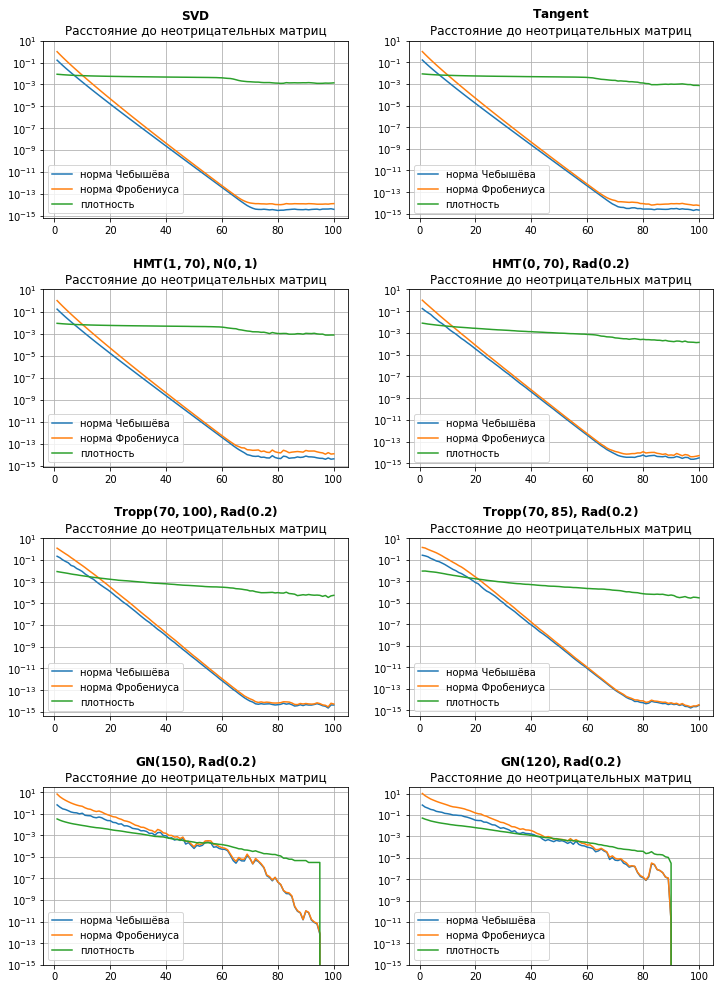

In [16]:
title = 'Расстояние до неотрицательных матриц'
info_list = [[matr_info_svd, matr_info_tangent],\
             [matr_info_hmt, matr_info_hmt2],\
             [matr_info_tropp, matr_info_tropp2],\
             [matr_info_gn, matr_info_gn2]]

fig, ax = plt.subplots(4, 2, figsize=(12, 17))

for i in range(4):
    for j in range(2):
        info = info_list[i][j].get_info()
        alg_name = info_list[i][j].get_name()
        ax[i,j].plot(range(1, 101), info['chebyshev'], colors[0], label=norms[0])
        ax[i,j].plot(range(1, 101), info['frobenius'],       colors[1], label=norms[1])
        ax[i,j].plot(range(1, 101), info['density'],   colors[2], label=norms[2])
        ax[i, j].set_title('$\\bf{%s}$\n%s' % (alg_name, title))
        ax[i, j].grid()
        ax[i, j].set_yscale('log')
        ax[i, j].set_yticks(yticks)
        ax[i, j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()

In [17]:
# for i in range(2):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 16.55
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'mat_1_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

In [18]:
labels = ['SVD', 'Tangent', 'HMT', 'HMT', 'Tropp', 'Tropp', 'GN', 'GN']
algs   = [SVD, Tangent, HMT, HMT, Tropp, Tropp, GN, GN]
params_list = [None, None,\
          dict(p=1, k=70,   distr='normal'),\
          dict(p=0, k=70,   distr='rademacher', rho=0.2),\
          dict(k=70, l=100, distr='rademacher', rho=0.2),\
          dict(k=70, l=85,  distr='rademacher', rho=0.2),\
          dict(l=150,       distr='rademacher', rho=0.2),\
          dict(l=120,       distr='rademacher', rho=0.2)]

for i in range(len(labels)):
    alg = algs[i]
    label = labels[i]
    params = params_list[i]
    
    print(label, params)
    if params is not None:
        %timeit alg(a, r, **params)
    else:
        %timeit alg(a, r)

SVD None
2.32 s ± 77.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tangent None
1.4 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
HMT {'p': 1, 'k': 70, 'distr': 'normal'}
1.45 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
HMT {'p': 0, 'k': 70, 'distr': 'rademacher', 'rho': 0.2}
889 ms ± 73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tropp {'k': 70, 'l': 100, 'distr': 'rademacher', 'rho': 0.2}
1.2 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tropp {'k': 70, 'l': 85, 'distr': 'rademacher', 'rho': 0.2}
1.25 s ± 83.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GN {'l': 150, 'distr': 'rademacher', 'rho': 0.2}
759 ms ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GN {'l': 120, 'distr': 'rademacher', 'rho': 0.2}
657 ms ± 62.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.2 B/W image

In [19]:
img = mpimg.imread('img.jpg')
img = img.mean(axis=2)
img /= 255
r = 50

ur, sr, vhr = svdr(img, r)
img_r = ur * sr @ vhr

_, s, _ = np.linalg.svd(img)
s = s/s[0]

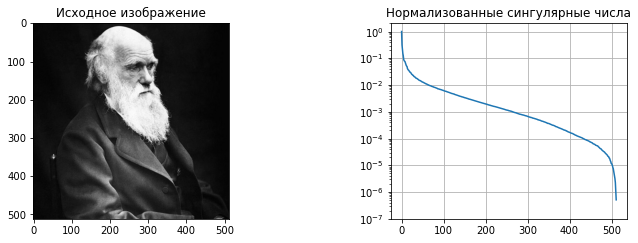

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3.6))
plt.subplots_adjust(wspace=0.6)

ax[0].set_title('Исходное изображение')
ax[0].imshow(img, cmap='gray')

ax[1].set_title(r'Нормализованные сингулярные числа')
ax[1].plot(range(len(s)), s)
ax[1].set_yscale('log')
ax[1].set_yticks([10**(-x) for x in range(-int(np.log10(s[-1]))+2)])
ax[1].grid()

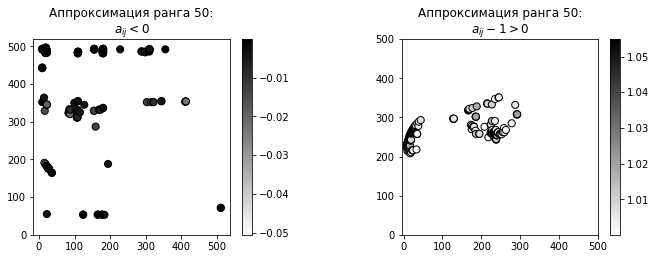

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3.6))
plt.subplots_adjust(wspace=0.5)

plt.set_cmap('gray_r')
ax[0].set_title('Аппроксимация ранга 50:\n$a_{ij} < 0$')
sc = ax[0].scatter(*np.where(img_r < 0), s=50, c=img_r[np.where(img_r < 0)], edgecolors='black')
plt.colorbar(sc, ax=ax[0])

ax[1].set_title('Аппроксимация ранга 50:\n$a_{ij} - 1 > 0$')
sc2 = ax[1].scatter(*np.where(img_r - 1 > 0), s=50, c=img_r[np.where(img_r - 1 > 0)], edgecolors='black')
plt.colorbar(sc2, ax=ax[1])

for i in range(2):
    ax[i].set_xticks(range(0, img.shape[0], 100))
    ax[i].set_yticks(range(0, img.shape[1], 100))

In [22]:
print('SVD...')
%timeit SVD(img, r, s=300, right=1)

print('Tangent...')
%timeit Tangent(img, r, s=300, right=1) 

print('HMT...')
%timeit HMT(img, r, p=0, k=60, distr='rademacher', rho=0.2, s=300, right=1)

print('Tropp...')
%timeit Tropp(img, r, k=60, l=120, distr='rademacher', rho=0.2, s=300, right=1) 

print('GN...')
%timeit GN(img, r, l=340, distr='rademacher', rho=0.2, s=300, right=1) 

SVD...
28.5 s ± 4.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tangent...
9.11 s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
HMT...
3.15 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tropp...
6.31 s ± 822 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GN...
5.82 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
img_info_svd = Info()
u, s, vh = SVD(img, r, s=300, right=1, info=img_info_svd)
img_svd = u * s @ vh

img_info_tangent = Info()
u, s, vh = Tangent(img, r, s=300, right=1, info=img_info_tangent) 
img_tangent = u * s @ vh

img_info_hmt = Info()
u, s, vh = HMT(img, r, p=0, k=60, distr='rademacher', rho=0.2, s=300, right=1, info=img_info_hmt) 
img_hmt = u * s @ vh

img_info_tropp = Info()
u, s, vh = Tropp(img, r, k=60, l=120, distr='rademacher', rho=0.2, s=300, right=1, info=img_info_tropp) 
img_tropp = u * s @ vh

img_info_gn = Info()
u, vh = GN(img, r, l=340, distr='rademacher', rho=0.2, s=300, right=1, info=img_info_gn) 
img_gn = u @ vh

In [24]:
print('--------------------------------')
print('SVD')
print('--------------------------------')
print('relative error (fro)   | %.5f' % (np.linalg.norm(img-img_svd) / np.linalg.norm(img)))
print('relative error (che)   | %.5f' % (np.max(abs(img-img_svd)) / np.max(abs(img))))
print('--------------------------------')
print('Tangent')
print('--------------------------------')
print('relative error (fro)   | %.5f' % (np.linalg.norm(img-img_tangent) / np.linalg.norm(img)))
print('relative error (che)   | %.5f' % (np.max(abs(img-img_tangent)) / np.max(abs(img))))
print('--------------------------------')
print('HMT')
print('--------------------------------')
print('relative error (fro)   | %.5f' % (np.linalg.norm(img-img_hmt) / np.linalg.norm(img)))
print('relative error (che)   | %.5f' % (np.max(abs(img-img_hmt)) / np.max(abs(img))))
print('--------------------------------')
print('Tropp')
print('--------------------------------')
print('relative error (fro)   | %.5f' % (np.linalg.norm(img-img_tropp) / np.linalg.norm(img)))
print('relative error (che)   | %.5f' % (np.max(abs(img-img_tropp)) / np.max(abs(img))))
print('--------------------------------')
print('GN')
print('--------------------------------')
print('relative error (fro)   | %.5f' % (np.linalg.norm(img-img_gn) / np.linalg.norm(img)))
print('relative error (che)   | %.5f' % (np.max(abs(img-img_gn)) / np.max(abs(img))))
print('--------------------------------')

--------------------------------
SVD
--------------------------------
relative error (fro)   | 0.06828
relative error (che)   | 0.37625
--------------------------------
Tangent
--------------------------------
relative error (fro)   | 0.06828
relative error (che)   | 0.37625
--------------------------------
HMT
--------------------------------
relative error (fro)   | 0.06832
relative error (che)   | 0.37626
--------------------------------
Tropp
--------------------------------
relative error (fro)   | 0.06840
relative error (che)   | 0.37620
--------------------------------
GN
--------------------------------
relative error (fro)   | 0.12501
relative error (che)   | 0.50600
--------------------------------


In [25]:
print('SVD_r')

%timeit svdr(img, 50)

ur, sr, vhr = svdr(img, 50)
_, s, _ = np.linalg.svd(img)
s = s/s[0]
img_r = ur * sr @ vhr

print('--------------------------------')
print('relative error (fro)   | %.5f'    % (np.linalg.norm(img-img_r) / np.linalg.norm(img)))
print('relative error (che)   | %.5f'    % (np.max(abs(img-img_r)) / np.max(abs(img))))

SVD_r
139 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
--------------------------------
relative error (fro)   | 0.06824
relative error (che)   | 0.37619


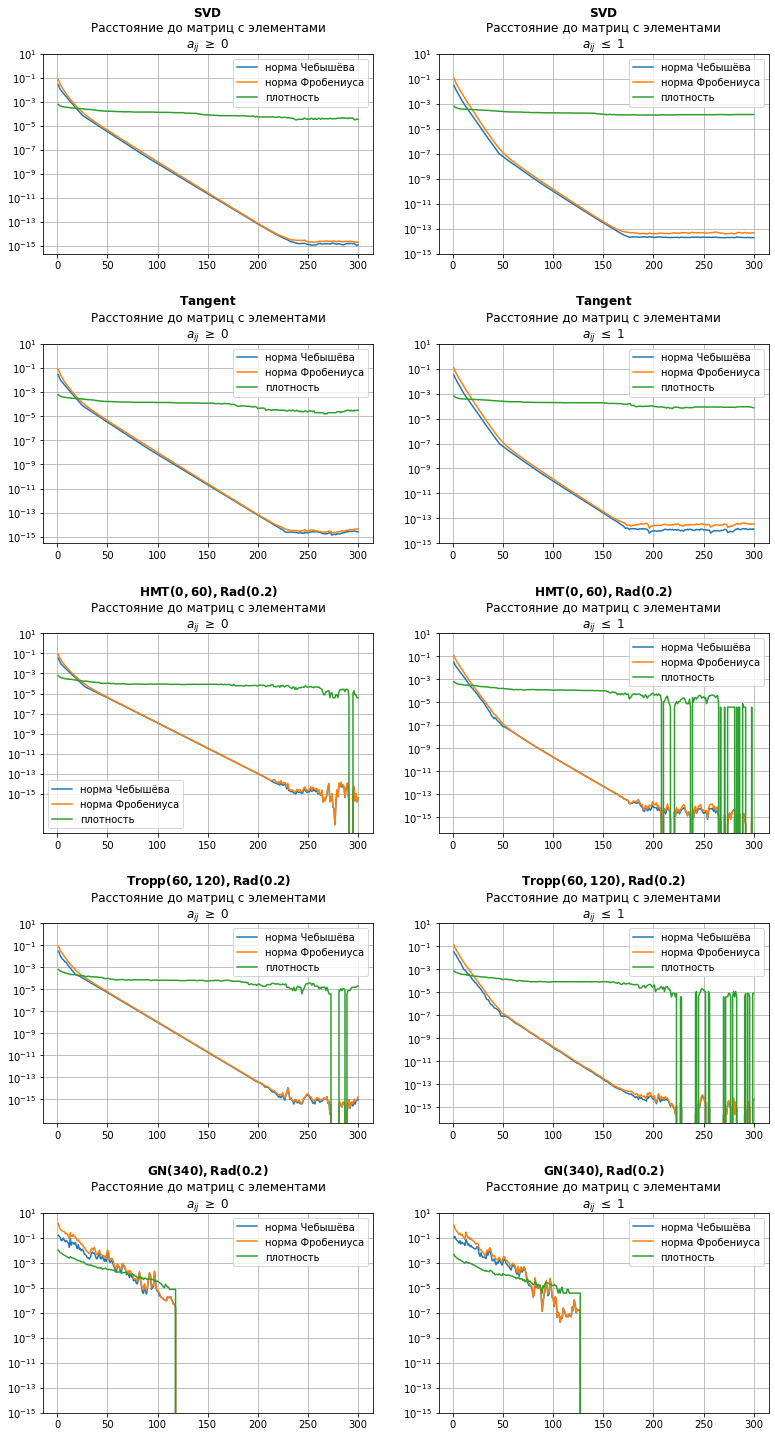

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(13, 25))

titles = ['Расстояние до матриц с элементами\n$a_{ij}$ $\geq$ 0', 'Расстояние до матриц с элементами\n$a_{ij}$ $\leq$ 1']
imgs = [img_svd, img_tangent, img_hmt, img_tropp, img_gn]
info_list = [img_info_svd, img_info_tangent, img_info_hmt, img_info_tropp, img_info_gn]
alg_names = [info.get_name() for info in info_list]

for i in range(5):
    alg_name = alg_names[i]
    info = info_list[i].get_info()
    for j in range(2):
        ax[i,j].plot(range(1, 301), info[j]['chebyshev'], colors[0], label=norms[0])
        ax[i,j].plot(range(1, 301), info[j]['frobenius'],       colors[1], label=norms[1])
        ax[i,j].plot(range(1, 301), info[j]['density'],   colors[2], label=norms[2])
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        ax[i,j].set_title('$\\bf{%s}$\n%s' % (alg_name, titles[j]))
        ax[i,j].legend()
        ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)
plt.show()

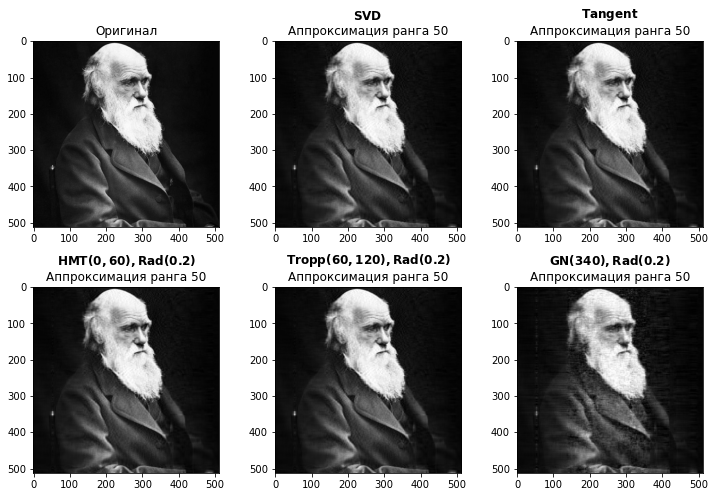

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

imgs = [img, img_svd, img_tangent, img_hmt, img_tropp, img_gn]
info_list = [img_info_svd, img_info_tangent, img_info_hmt, img_info_tropp, img_info_gn]
alg_names = [info.get_name() for info in info_list]
titles = ['Оригинал'] + alg_names
subt = f'Аппроксимация ранга {r}' 

for i in range(2):
    for j in range(3):
        if i + j == 0:
            ax[i,j].set_title('%s' % titles[i*3+j])
        else:
            ax[i,j].set_title('$\\bf{%s}$\n%s' % (titles[i*3+j], subt))
        ax[i,j].set_xticks(range(0, 513, 100))
        ax[i,j].imshow(imgs[i*3+j], cmap='gray')
        
plt.subplots_adjust(wspace=0.3, hspace=0.3)